In [3]:
import dill
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
path_name = "../dataset/data/"

with open(path_name + 'comment-pos.data', 'rb') as file:
    datatofile = dill.load(file)

tagged_sents = []
for data in datatofile:
    text_inside = []
    for word, pos, label in data:
        if word.strip() == '':
            text_inside.append(('_', label))
        else:
            text_inside.append((word, label))
    tagged_sents.append(text_inside)

train_sents, test_sents = train_test_split(tagged_sents, test_size=0.2, random_state=42)
print(len(train_sents))
print(len(test_sents))
print(train_sents[1])

552
138
[('ถ้า', 'B-c'), ('เดินทาง', 'I-c'), ('กลางคืน', 'I-c'), ('ก็', 'I-c'), ('รถทัวร์', 'I-c'), ('ครับ', 'I-c'), ('_', 'I-c'), ('_', 'O'), ('เพราะ', 'B-p'), ('รถ', 'I-p'), ('ไม่', 'I-p'), ('เยอะ', 'I-p'), ('_', 'I-p'), ('ความเสี่ยง', 'I-p'), ('การ', 'I-p'), ('เกิด', 'I-p'), ('อุบัติ', 'I-p'), ('ห', 'I-p'), ('ตุ', 'I-p'), ('ก็', 'I-p'), ('น้อย', 'I-p'), ('(', 'I-p'), ('มั้ง', 'I-p'), (')', 'I-p'), ('_', 'I-p'), ('_', 'O'), ('ถ้า', 'B-c'), ('กลางวัน', 'I-c'), ('ก็', 'I-c'), ('เครื่องบิน', 'I-c'), ('ครับ', 'I-c'), ('_', 'I-c'), ('_', 'O'), ('เพราะ', 'B-p'), ('_', 'I-p'), ('มัน', 'I-p'), ('ใช้เวลา', 'I-p'), ('น้อย', 'I-p'), ('จะ', 'I-p'), ('ได้', 'I-p'), ('มี', 'I-p'), ('เวลา', 'I-p'), ('ระหว่าง', 'I-p'), ('วัน', 'I-p'), ('เยอะ', 'I-p'), ('ๆ', 'I-p'), ('_', 'I-p')]


In [5]:
def convert_to_simple_transformer_format(sentences):
    sentence_id = []
    words = []
    labels = []

    for idx, sents in enumerate(sentences):
        for word, label in sents:
            label = label.upper().replace("-", "_")
            sentence_id.append(idx)
            words.append(word)
            labels.append(label)
    return pd.DataFrame(
        {"sentence_id": sentence_id, "words": words, "labels": labels}
    )    

In [6]:
train_ = convert_to_simple_transformer_format(train_sents)
train_

,sentence_id,words,labels
0,0,อะไหล่,B_C
1,0,เทอร์โบ,I_C
2,0,_,I_C
3,0,อี,I_C
4,0,ซุ,I_C
...,...,...,...
37405,551,ทำ,I_P
37406,551,อะไร,I_P
37407,551,ได้,I_P
37408,551,หลายอย่าง,I_P


In [7]:
test_ = convert_to_simple_transformer_format(test_sents)

In [8]:
import torch
from simpletransformers.ner import NERModel, NERArgs

_NER_TAGS = ["O", "B_C", "B_P", "I_C", "I_P"]
ner_args = NERArgs()
ner_args.max_seq_length = 512
test_ner = NERModel("bert", 'model_seq_512/save_model', args=ner_args, use_cuda=torch.cuda.is_available(), labels=_NER_TAGS)

In [9]:
test_list = []
for sent in test_sents:
    words = []
    for word, label in sent:
        words.append(word)
    test_list.append(words)

predictions, raw_outputs = test_ner.predict(test_list, split_on_space=False)

Running Prediction: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


In [10]:
predictions_ = []
for sent in predictions:
    sent_ = []
    for word_lable in sent:
        sent_.append(list(word_lable.items())[0])
    predictions_.append(sent_)

In [11]:
# get label test list
y_test = []
for sent in test_sents:
    labels = []
    for word, label in sent:
        label = label.upper().replace("-", "_")
        labels.append(label)
    y_test.append(labels)
    
# print(y_test[1])


In [12]:
# get label pred list
test_list = []
for sent in test_sents:
    words = []
    for word, label in sent:
        words.append(word)
    test_list.append(words)

predictions, raw_outputs = test_ner.predict(test_list, split_on_space=False)

y_pred = []
for preds in predictions:
    y_pred.append([list(pred.items())[0][1] for pred in preds])

# print(y_pred[1])

Running Prediction: 100%|██████████| 18/18 [00:11<00:00,  1.61it/s]


# find problems

## ปัญหา
#### ติด ๆ แยกจากกันตรง index ที่ 10 (แก้แล้ว)
#### ติด เวลา predict มีการตัดข้อความทำให้ ข้อความ predict ไม่เท่ากับ test

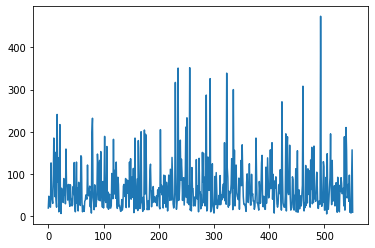

In [13]:
import matplotlib.pyplot as plt

plt.plot(list(map(lambda x: len(x), train_sents)))

In [14]:
# หาlabel ที่มีจำนวนไม่เท่ากัน
y_pred_ = []
y_test_ = []
for i in range(len(y_test)):
    if len(y_pred[i]) != len(y_test[i]):
        # print(len(y_pred[i]), len(y_test[i]))
        print(i, end=" ")
        continue;
    y_pred_.append(y_pred[i])
    y_test_.append(y_test[i])

6 

In [15]:
# หาค่า max ของ y_pred
print("max: ", max(list(map(lambda x: len(x), y_pred))))

for i in range(len(y_test)):
    if len(y_test[i]) > 468:
        print(i, end=" ")

max:  478
6 

In [21]:
idx_ = 6
print(len(predictions_[idx_]))
print(predictions_[idx_])

478
[('-', 'O'), ('_', 'I_C'), ('สาย', 'O'), ('สามัญ', 'O'), ('_', 'O'), ('ดีกว่า', 'I_P'), ('_', 'I_P'), ('ตรง', 'I_P'), ('ที่', 'I_P'), ('สามารถ', 'I_P'), ('ต่อ', 'I_P'), ('_', 'I_P'), ('ป.', 'I_P'), ('ตรี', 'I_P'), ('_', 'I_P'), ('ได้', 'I_P'), ('_', 'I_P'), ('ทุก', 'I_P'), ('มหาวิทยาลัย', 'I_P'), ('_', 'O'), ('ทุก', 'I_P'), ('คณะ', 'I_P'), ('_', 'I_P'), ('ทุก', 'I_P'), ('สาขา', 'I_P'), ('_', 'I_P'), ('(', 'I_P'), ('โดยเฉพาะ', 'O'), ('_', 'I_P'), ('ม.', 'I_P'), ('ปลาย', 'I_P'), ('_', 'O'), ('สาย', 'O'), ('วิทย์', 'O'), ('-', 'O'), ('คณิต', 'O'), ('_', 'O'), ('ที่', 'O'), ('เลือก', 'O'), ('สมัคร', 'O'), ('_', 'O'), ('สอบ', 'O'), ('_', 'O'), ('เรียนต่อ', 'O'), ('ได้', 'O'), ('ทุก', 'O'), ('สาขาวิชา', 'O'), ('_', 'O'), ('ทุก', 'O'), ('คณะ', 'O'), (')', 'O'), ('_', 'O'), ('จะ', 'O'), ('สมัคร', 'O'), ('สอบ', 'O'), ('เข้า', 'O'), ('_', 'O'), ('ม.', 'O'), ('รัฐ', 'O'), ('ชื่อดัง', 'O'), ('ต่างๆ', 'O'), ('_', 'O'), ('เช่น', 'O'), ('_', 'O'), ('จุฬา', 'O'), (',', 'O'), ('_', 'O'), ('ธรรมศาสต

In [22]:
print(len(test_sents[idx_]))
print(test_sents[idx_])

744
[('-', 'O'), ('_', 'O'), ('สาย', 'B-c'), ('สามัญ', 'I-c'), ('_', 'I-c'), ('ดีกว่า', 'I-c'), ('_', 'O'), ('ตรง', 'B-p'), ('ที่', 'I-p'), ('สามารถ', 'I-p'), ('ต่อ', 'I-p'), ('_', 'I-p'), ('ป.', 'I-p'), ('ตรี', 'I-p'), ('_', 'I-p'), ('ได้', 'I-p'), ('_', 'I-p'), ('ทุก', 'I-p'), ('มหาวิทยาลัย', 'I-p'), ('_', 'I-p'), ('ทุก', 'I-p'), ('คณะ', 'I-p'), ('_', 'I-p'), ('ทุก', 'I-p'), ('สาขา', 'I-p'), ('_', 'O'), ('(', 'O'), ('โดยเฉพาะ', 'O'), ('_', 'O'), ('ม.', 'O'), ('ปลาย', 'O'), ('_', 'O'), ('สาย', 'O'), ('วิทย์', 'O'), ('-', 'O'), ('คณิต', 'O'), ('_', 'O'), ('ที่', 'O'), ('เลือก', 'O'), ('สมัคร', 'O'), ('_', 'O'), ('สอบ', 'O'), ('_', 'O'), ('เรียนต่อ', 'O'), ('ได้', 'O'), ('ทุก', 'O'), ('สาขาวิชา', 'O'), ('_', 'O'), ('ทุก', 'O'), ('คณะ', 'O'), (')', 'O'), ('_', 'O'), ('จะ', 'O'), ('สมัคร', 'O'), ('สอบ', 'O'), ('เข้า', 'O'), ('_', 'O'), ('ม.', 'O'), ('รัฐ', 'O'), ('ชื่อดัง', 'O'), ('ต่างๆ', 'O'), ('_', 'O'), ('เช่น', 'O'), ('_', 'O'), ('จุฬา', 'O'), (',', 'O'), ('_', 'O'), ('ธรรมศาสตร์', '